# Timepix Images (Fe Sample and Open Beam)

In [1]:
%matplotlib widget

In [2]:
from ess.imaging.data import get_fe_timepix_image_path, get_ob_timepix_image_path
from ess.imaging.io import load_tiff

sample_image_path = get_fe_timepix_image_path()
openbeam_image_path = get_ob_timepix_image_path()

## Define Workflow

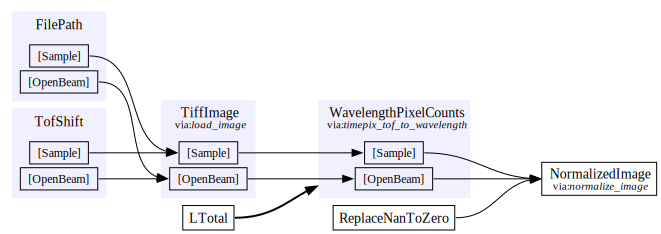

In [3]:
import pathlib

import scipp as sc
import sciline as sl

from typing import NewType, TypeVar

Sample = NewType('Sample', int)
OpenBeam = NewType('OpenBeam', int)
RunType = TypeVar('RunType', Sample, OpenBeam)


class FilePath(sl.Scope[RunType, pathlib.Path], pathlib.Path): ...


class TiffImage(sl.Scope[RunType, sc.DataArray], sc.DataArray): ...


NormalizedImage = NewType('NormalizedImage', sc.DataArray)


class TofShift(sl.Scope[RunType, int], int): ...


"""The number of indices to shift the time of arrival (tof) axis.

For example, if there are 6 images in the tiff stack
and the tof of each images are [3, 4, 5, 6, 1, 2], the tof shift indices is 2.

It happens because the trigger of the timepix is delayed by n-seconds
from the pulse signal of the neutron source.
Since the tiff image stack does not have a time coordinate,
it is easier for users to specify the tof shift in terms of indices
instead of time values.

"""


DEFAULT_TOF_SHIFT = TofShift(0)


def load_image(
    path: FilePath[RunType], tof_shift: TofShift[RunType] = DEFAULT_TOF_SHIFT
) -> TiffImage[RunType]:
    easier_dims = {'dim_0': 'x', 'dim_1': 'y', 'dim_2': 'tof'}
    img = load_tiff(path, dtype=float, with_variances=True).rename_dims(easier_dims)
    # Hard-code the time coordinate
    tof_coord = sc.linspace(
        dim='tof', start=0.0, stop=40.0, num=img.sizes['tof'], unit='ms'
    )
    tof_coord = sc.concat([tof_coord[-tof_shift:], tof_coord[:-tof_shift]], dim='tof')
    img.coords['tof'] = tof_coord
    # Hard-code the positional coordinates
    img.coords['x'] = sc.linspace(
        dim='x', start=0, stop=10.0, num=img.sizes['x'] + 1, unit='cm'
    )
    img.coords['y'] = sc.linspace(
        dim='y', start=0, stop=10.0, num=img.sizes['y'] + 1, unit='cm'
    )
    sorted_img = sc.sort(img, 'tof')
    sorted_img.coords['tof'] = sc.linspace(
        dim='tof', start=0.0, stop=40.0, num=img.sizes['tof'] + 1, unit='ms'
    )
    return sorted_img


ReplaceNanToZero = NewType('ReplaceNanToZero', bool)
DEFAULT_REPLACE_NAN_TO_ZERO = ReplaceNanToZero(True)
LTotal = NewType('LTotal', sc.Variable)


class WavelengthPixelCounts(sl.Scope[RunType, sc.DataArray], sc.DataArray): ...


def timepix_tof_to_wavelength(
    l_total: LTotal, tiff_image: TiffImage[RunType]
) -> WavelengthPixelCounts[RunType]:
    from scippneutron.conversion import graph

    tiff_image.coords['Ltotal'] = l_total
    plane_graph = graph.tof.kinematic("tof")
    transformed = tiff_image.transform_coords('wavelength', graph=plane_graph)
    return WavelengthPixelCounts[RunType](transformed)


def normalize_image(
    sample_img: WavelengthPixelCounts[Sample],
    openbeam_img: WavelengthPixelCounts[OpenBeam],
    replace_nan_to_zero: ReplaceNanToZero,
) -> NormalizedImage:
    """
    Normalize the sample image with open beam image /pixel and /time(wavelength)

    ``nan`` values can occur if any pixels of `open beam` has `0` counts.
    ``nan`` values are masked.
    """
    normalized = sample_img / openbeam_img
    normalized.masks['no-ob'] = sc.isnan(normalized.data)
    if replace_nan_to_zero:
        zero = sc.scalar(0.0, unit=normalized.unit)
        zero.variance = zero.value
        normalized.data = sc.nan_to_num(
            normalized.data, neginf=zero, posinf=zero, nan=zero
        )
    return NormalizedImage(normalized)


wf = sl.Pipeline(
    providers=[load_image, timepix_tof_to_wavelength, normalize_image],
    params={
        FilePath[Sample]: sample_image_path,
        FilePath[OpenBeam]: openbeam_image_path,
        TofShift[Sample]: 0,
        TofShift[OpenBeam]: 0,
        LTotal: sc.scalar(34.8, unit='m'),
        ReplaceNanToZero: DEFAULT_REPLACE_NAN_TO_ZERO,
    },
)
wf.visualize(NormalizedImage, graph_attr={'rankdir': 'LR'})

In [4]:
images = wf.compute(
    (WavelengthPixelCounts[Sample], WavelengthPixelCounts[OpenBeam], NormalizedImage)
)
sample_img = images[WavelengthPixelCounts[Sample]]
openbeam_img = images[WavelengthPixelCounts[OpenBeam]]
normalized_img = images[NormalizedImage]

In [5]:
normalized_img

<scipp.DataArray>
Dimensions: Sizes[wavelength:250, y:128, x:128, ]
Coordinates:
  Ltotal                    float64              [m]  ()  34.8
  tof                       float64             [ms]  (wavelength [bin-edge])  [0, 0.16, ..., 39.84, 40]
* wavelength                float64             [Å]  (wavelength [bin-edge])  [0, 0.0181887, ..., 4.52898, 4.54717]
* x                         float64             [cm]  (x [bin-edge])  [0, 0.078125, ..., 9.92188, 10]
* y                         float64             [cm]  (y [bin-edge])  [0, 0.078125, ..., 9.92188, 10]
Data:
                            float64  [dimensionless]  (wavelength, y, x)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]
Masks:
  no-ob                        bool        <no unit>  (wavelength, y, x)  [True, True, ..., True, True]

## Visualize Images
### Raw Images (Sample and OpenBeam)

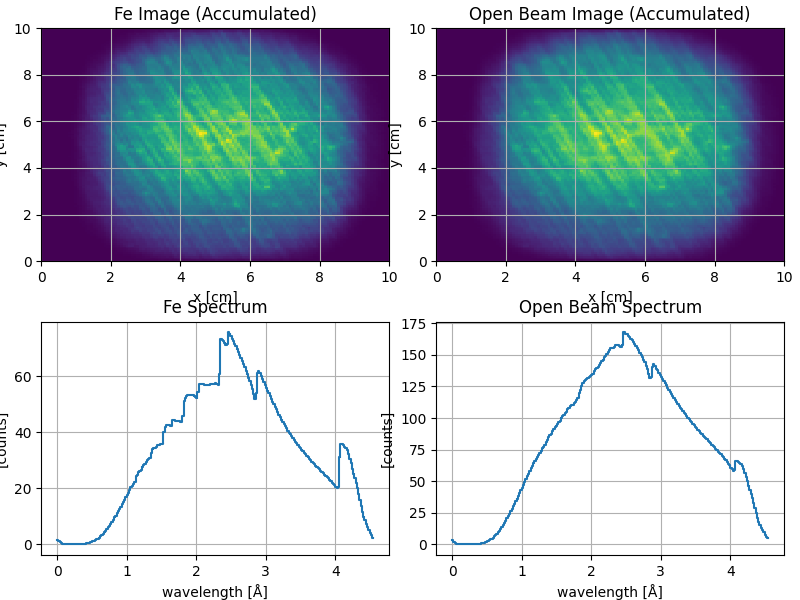

In [6]:
sample_2d = sample_img.mean('wavelength').plot(
    title='Fe Image (Accumulated)', grid=True, cbar=False
)
openbeam_2d = openbeam_img.mean('wavelength').plot(
    title='Open Beam Image (Accumulated)', grid=True, cbar=False
)

sample_1d = sample_img.mean('x').mean('y').plot(title='Fe Spectrum', grid=True)
openbeam_1d = (
    openbeam_img.mean('x').mean('y').plot(title='Open Beam Spectrum', grid=True)
)

tiled = (sample_2d + openbeam_2d) / (sample_1d + openbeam_1d)
tiled.fig.set_size_inches(8, 6)
tiled

### Normalized Images

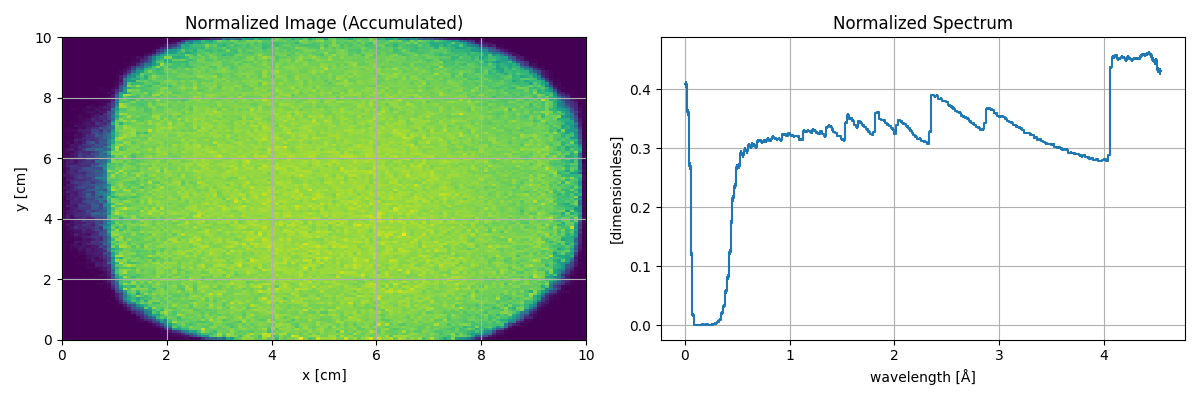

In [7]:
# Handle NaNs
normalized_img.masks['no-ob'] = sc.isnan(normalized_img.data)
replaced = sc.scalar(0.0, unit='dimensionless')
replaced.variance = 0
normalized_img.data = sc.nan_to_num(normalized_img.data, posinf=replaced)
# 2D
normed_2d_da = normalized_img.mean('wavelength')
normed_2d_da.masks['no-ob'] = normalized_img.masks['no-ob'].all('wavelength')
normed_2d = normed_2d_da.plot(
    title='Normalized Image (Accumulated)', grid=True, cbar=False
)
# 1D
normed_1d_da = normalized_img.mean('x').mean('y')
normed_1d = normed_1d_da.plot(title='Normalized Spectrum', grid=True)
normed_2d + normed_1d

Since the image contains area without sample, a Region Of Interest (ROI) needs to be chosen for which the spektra can be used for analysis.

## ROI Selection Tool

In [8]:
import plopp as pp
from plopp.widgets.tools import ToggleTool
from mpltoolbox import Rectangles


class RectInfo(sc.DataGroup):
    @property
    def min_x(self) -> sc.Variable:
        return self['min_x']

    @property
    def max_x(self) -> sc.Variable:
        return self['max_x']

    @property
    def min_y(self) -> sc.Variable:
        return self['min_y']

    @property
    def max_y(self) -> sc.Variable:
        return self['max_y']

    def __init__(
        self,
        min_x: sc.Variable,
        max_x: sc.Variable,
        min_y: sc.Variable,
        max_y: sc.Variable,
    ):
        super().__init__(
            {'min_x': min_x, 'max_x': max_x, 'min_y': min_y, 'max_y': max_y}
        )


def _get_rect_info(artist, figure) -> RectInfo:
    """
    Convert the raw rectangle info to a ``RectInfo`` object.
    each axis, and values with units.
    """
    x_range = sc.array(
        dims=['x'],
        values=[artist.xy[1], artist.xy[1] + artist.height],
        unit=figure.canvas.units['x'],
    )
    y_range = sc.array(
        dims=['y'],
        values=[artist.xy[0], artist.xy[0] + artist.width],
        unit=figure.canvas.units['y'],
    )
    return RectInfo(x_range.min(), x_range.max(), y_range.min(), y_range.max())


class MergedRectanglesTool(ToggleTool):
    def __init__(self, figure, destination, value: bool = False, **kwargs):
        super().__init__(callback=self.start_stop, value=value, **kwargs)

        self._figure = figure
        self._tool = Rectangles(
            ax=self._figure.ax, autostart=kwargs.get('autostart', False)
        )
        self.rectangles = []
        self._draw_node = pp.Node(lambda: self.rectangles)  # Empty rectangle info.
        self._destination = destination
        self._destination.add_parents(self._draw_node)
        self._tool.on_create(self.update_node)
        self._tool.on_vertex_release(self.update_node)
        self._tool.on_drag_release(self.update_node)
        self._tool.on_remove(self.update_node)

    def update_node(self, _):
        self.rectangles = [
            _get_rect_info(artist=artist, figure=self._figure)
            for artist in self._tool.children
        ]
        self._draw_node.func = lambda: self.rectangles
        self._draw_node.notify_children("")  # Empty message.

    def start_stop(self):
        """
        Toggle start or stop of the tool.
        """
        if self.value:
            self._tool.start()
        else:
            self._tool.stop()


In [9]:
# Prepare the merge method
from functools import reduce


def _show_histogram(da: sc.DataArray, rect_infos: list[RectInfo]) -> sc.DataArray:
    if len(rect_infos) > 0:
        masks = [
            (normalized_img.coords['x'] > rect_info.max_x)
            | (normalized_img.coords['x'] < rect_info.min_x)
            | (normalized_img.coords['y'] > rect_info.max_y)
            | (normalized_img.coords['y'] < rect_info.min_y)
            for rect_info in rect_infos
        ]
        mask = reduce(lambda x, y: x & y, masks)
        selected_sample_region = da.copy(deep=False)
        selected_sample_region.masks['roi'] = mask['x', :-1]['y', :-1]
        # Calculate ``nanmean`` since the mask is applied.
        # Number of pixels in the masked region can be 0.
        return selected_sample_region.nanmean('x').nanmean('y')
    else:
        # Calculate ``nanmean`` since the mask may be applied.
        # Number of pixels in the masked region can be 0.
        return da.nanmean('x').nanmean('y')


original_data_node = pp.Node(normalized_img)
merge_node = pp.Node(_show_histogram)
merge_node.add_parents(original_data_node)

In [10]:
data_node = pp.Node(normalized_img.sum('wavelength'))
f2d = pp.imagefigure(
    data_node, norm='log', title="Region of Interest Selection", cbar=True
)

roi_merge_tool = MergedRectanglesTool(
    figure=f2d, destination=merge_node, icon='vector-square'
)
f1d = pp.linefigure(merge_node, title="Wavelength Spectrum in ROI", grid=True, vmin=0)

In [11]:
from plopp.widgets import HBar

f2d.toolbar['roi-merged'] = roi_merge_tool
box = HBar([f2d, f1d])
box  # TODO: These ROI tools should be reusable easily with other data.

HBar(children=(InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(…

In the above image on the left, choose the bottom button, click on a point in the sample, and click again somewhere else to define the 2 corners of the ROI. The spectrum on the right will change live accordingly.

### Use and slice ROI regions

In [16]:
rois = sc.DataGroup(
    {
        f'rectangle_{i}': rectangle
        for i, rectangle in enumerate(roi_merge_tool.rectangles)
    }
)
hist = _show_histogram(normalized_img, list(rois.values()))
hist.plot(title='ROI Spectrum', grid=True)

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

Since the data contains very few counts for the low and high end of the spectra (see the raw Fe Image and Open Beam image higher up in the notebook), the normalized spectra in these regions are errorful and needs to be cut out before analysis

In [17]:
lower_bound = 1.0 * sc.Unit('Å')
upper_bound = 4.2 * sc.Unit('Å')

In [18]:
sliced_data = hist["wavelength", lower_bound:upper_bound]
sliced_data.plot(title='Cutoff ROI Spectrum', grid=True)

InteractiveFigure(children=(HBar(), HBar(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', la…

In [19]:
# Taking out the values and saving them as arrays
wavelengths = sc.midpoints(sliced_data.coords["wavelength"]).values
transmissions = sliced_data.values
transmissions_variances = sliced_data.variances

## Physical model with Ncrystal

## Inspecting the model

In [20]:
import NCrystal
import NCrystal.plot
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# We initalize the model
mat = NCrystal.NCMATComposer()

In [22]:
# We set the model parameters to Iron (slightly off on purpose)
mat.set_cellsg_cubic(2.90)
mat.set_atompos([   ('Fe',0,0,0),
                    ('Fe',0.5, 0.5, 0.5),
                    ])
mat.set_dyninfo_debyetemp("Fe", debye_temp=356)
mat.set_default_temperature(250)
mat.refine_crystal_structure(quiet=True)

In [23]:
scatter = mat.load(#cfg_params="comp=inelas"
                    )

In [24]:
scatter.info.getNumberDensity()

0.08200418221329288

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: <anonymous-ncmat-data>
----------------------------------------------------------------------------------------------------
Density : 7.60478 g/cm3, 0.0820042 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Fe
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Fe
----------------------------------------------------------------------------------------------------
Atom data:
   Fe = Fe(cohSL=9.45fm cohXS=11.2221barn incXS=0.4barn absXS=2.56barn mass=55.8472u Z=26)
-----------------------------------------------

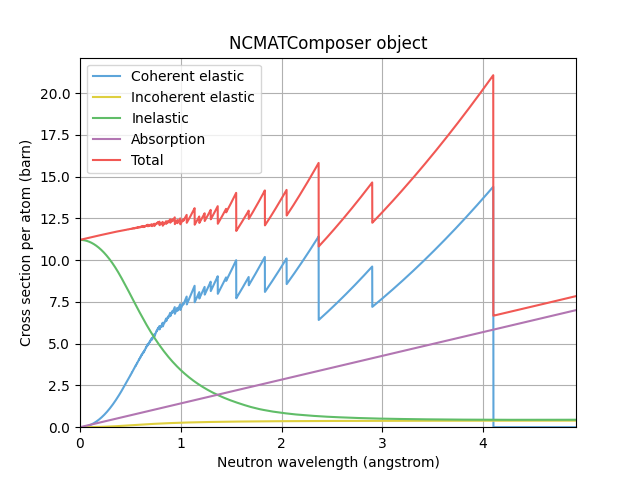

In [25]:
# Information about the model can be viewed with this method
mat.inspect()

In [26]:
# And a short summary can be viewed by printing
print(mat())

NCMAT v7
# Autogenerated by NCMATComposer
#
# Fe (cubic, SG-229)
#
# Atoms per unit cell: 2xFe
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 2.9
@SPACEGROUP
  229
@ATOMPOSITIONS
  Fe 0 0 0
  Fe 1/2 1/2 1/2
@TEMPERATURE
  default 250
@DYNINFO
  element Fe
  fraction 1
  type vdosdebye
  debye_temp 356



Calculating the simulated spectrum using this model

In [27]:
scatter = mat.load(#cfg_params="comp=inelas"
                    )
absorptions = scatter.absorption.xsect(wl=wavelengths)
scattered = scatter.scatter.xsect(wl=wavelengths)
# Using an arbitrary scale constant of 0.05 to scale cross sections and absorptions. Depends on width of material in a real model.
simulated = np.exp(-0.05*(absorptions+scattered))

### Loading reference Iron slab data from J-PARC

In [28]:
with open('Iron_slab.dat', 'r') as file:
    slab_data = file.readlines()

In [29]:
slab_wavelengths = np.asarray([float(slab_data[i].split("\t")[1]) for i in range(len(slab_data)-1)])
slab_transmissions = np.asarray([float(slab_data[i].split("\t")[2]) for i in range(len(slab_data)-1)])

### Comparing Data sets and initial model

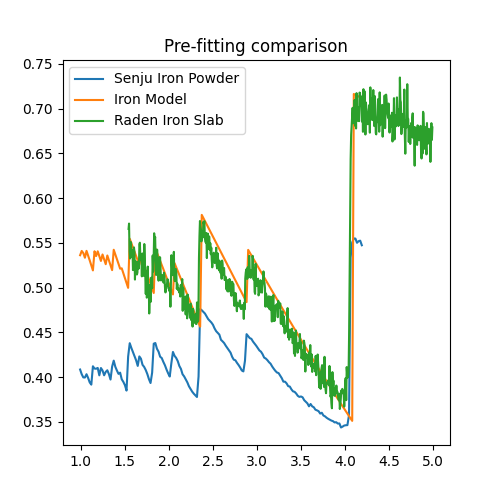

In [30]:
plt.figure(figsize=(5,5))
plt.plot(wavelengths, sliced_data.values, label='Senju Iron Powder')
#plt.plot(wavelengths, transmissions, label="Data")
plt.plot(wavelengths, simulated, label="Iron Model")
plt.plot(slab_wavelengths, slab_transmissions, label='Raden Iron Slab')
plt.title("Pre-fitting comparison")
plt.legend()
plt.show()

## Bragg-edge fitting with Ncrystal and EasyScience

In [31]:
from easyscience.Objects.new_variable import Parameter
from easyscience.Objects.ObjectClasses import BaseObj
from easyscience.fitting import Fitter

### Setting up the fitting models

Defining the fitting parameters and their initial values \
We're defining 2 sets of parameters because we want to fit a model to both sets of data

In [32]:
lattice_constant =  Parameter(name="Lattice constant",          value=2.85, unit="angstrom",    min=0,  max=4,    fixed=False)
debye_temperature = Parameter(name="Debye temperature",         value=300,  unit="kelvin",      min=100,  max=800,  fixed=False)
temperature =       Parameter(name="Temperature",               value=300,  unit="kelvin",      min=0,  max=600,  fixed=False)
intensity_scale =   Parameter(name="Intensity scale factor",    value=0.05,                      fixed=False)

In [33]:
lattice_constant_slab =  Parameter(name="Lattice constant",          value=2.85, unit="angstrom",    min=0,  max=4,    fixed=False)
debye_temperature_slab = Parameter(name="Debye temperature",         value=300,  unit="kelvin",      min=100,  max=800,  fixed=False)
temperature_slab =       Parameter(name="Temperature",               value=300,  unit="kelvin",      min=0,  max=600,  fixed=False)
intensity_scale_slab =   Parameter(name="Intensity scale factor",    value=0.05,                      fixed=False)

Defining the fit functions to go into EasyScience

In [34]:
def iron_bragg(wavelength):
    # Initalize the NCrystal material composer
    material = NCrystal.NCMATComposer()
    # Set the material parameters with the fitting variables
    material.set_cellsg_cubic(lattice_constant.value)
    material.set_atompos([  ('Fe',0,0,0),
                            ('Fe',0.5, 0.5, 0.5),
                            ])
    material.set_dyninfo_debyetemp("Fe", debye_temp=debye_temperature.value)
    material.set_default_temperature(temperature.value)

    # Identify the space group from atomic positions
    material.refine_crystal_structure(quiet=True)

    #print("lattice constant:", lattice_constant.value)
    scatter = material.load()

    # Create scattering spectrum
    spectrum = np.exp(-intensity_scale.value*(scatter.scatter.xsect(wl=wavelength) + scatter.absorption.xsect(wl=wavelength)))
    return spectrum

def iron_bragg_slab(wavelength):
    # Initalize the NCrystal material composer
    material = NCrystal.NCMATComposer()
    # Set the material parameters with the fitting variables
    material.set_cellsg_cubic(lattice_constant_slab.value)
    material.set_atompos([  ('Fe',0,0,0),
                            ('Fe',0.5, 0.5, 0.5),
                            ])
    material.set_dyninfo_debyetemp("Fe", debye_temp=debye_temperature_slab.value)
    material.set_default_temperature(temperature_slab.value)

    # Identify the space group from atomic positions
    material.refine_crystal_structure(quiet=True)

    #print("lattice constant:", lattice_constant.value)
    scatter = material.load()

    # Create scattering spectrum
    spectrum = np.exp(-intensity_scale_slab.value*(scatter.scatter.xsect(wl=wavelength) + scatter.absorption.xsect(wl=wavelength)))
    return spectrum

Make the EasyScience container for the fitting parameters

In [35]:
iron_spectrum = BaseObj(
                        name='Iron transmission spectrum', 
                        lattice_constant=lattice_constant, 
                        debye_temperature=debye_temperature,
                        temperature=temperature,
                        intensity_scale=intensity_scale,
                        )
iron_spectrum_slab = BaseObj(
                        name='Iron transmission spectrum slab', 
                        lattice_constant_slab=lattice_constant_slab, 
                        debye_temperature_slab=debye_temperature_slab,
                        temperature_slab=temperature_slab,
                        intensity_scale_slab=intensity_scale_slab,
                        )

Make the EasyScience fitting objects

In [36]:
fitter = Fitter(iron_spectrum, iron_bragg)
fitter_slab = Fitter(iron_spectrum_slab, iron_bragg_slab)

EasyScience can fit data with a variety of different minimizers. To list the available methods, use the "available_minimizers" method:

In [37]:
fitter.available_minimizers

['LMFit',
 'LMFit_leastsq',
 'LMFit_powell',
 'LMFit_cobyla',
 'LMFit_differential_evolution',
 'LMFit_scipy_least_squares',
 'Bumps',
 'Bumps_simplex',
 'Bumps_newton',
 'Bumps_lm',
 'DFO',
 'DFO_leastsq']

For the fits in this notebook, we will use "LMFit_leastsq" which is a standard leastsquares fitting method

In [38]:
fitter.switch_minimizer("LMFit_leastsq")
fitter_slab.switch_minimizer("LMFit_leastsq")

minimizer should be set with enum LMFit_leastsq
minimizer should be set with enum LMFit_leastsq


### Fitting

First we fit the reduced Iron powder data

In [39]:
# Parameters for LMFit_leastsq
results = fitter.fit(x=wavelengths, y=transmissions, 
                     weights=1/np.sqrt(transmissions_variances), 
                     minimizer_kwargs={"epsfcn":0.005,
                                       "ftol":1.49012e-15,
                                       "xtol":1.49012e-15,
                                       },
                    #max_nfev=10000
                     )

Print the fitted values

In [40]:
print(lattice_constant)
print(debye_temperature)
print(temperature)
print(intensity_scale)

<Parameter 'Lattice constant': 2.8873 ± 0.0035 Å, bounds=[0.0:4.0]>
<Parameter 'Debye temperature': 123.3785 ± 6.0105 K, bounds=[100.0:800.0]>
<Parameter 'Temperature': 165.3925 ± 23.1044 K, bounds=[0.0:600.0]>
<Parameter 'Intensity scale factor': 0.0647 ± 0.0011, bounds=[-inf:inf]>


We then fit the reference Iron slab data

In [41]:
# Parameters for LMFit_leastsq
results_slab = fitter_slab.fit(x=slab_wavelengths, y=slab_transmissions, 
                     #weights=1/np.sqrt(transmissions_variances), 
                     minimizer_kwargs={"epsfcn":0.005,
                                       "ftol":1.49012e-15,
                                       "xtol":1.49012e-15,
                                       },
                    #max_nfev=10000
                     )

In [42]:
print(lattice_constant_slab)
print(debye_temperature_slab)
print(temperature_slab)
print(intensity_scale_slab)

<Parameter 'Lattice constant': 2.8736 ± 0.0009 Å, bounds=[0.0:4.0]>
<Parameter 'Debye temperature': 296.3930 ± 51.0505 K, bounds=[100.0:800.0]>
<Parameter 'Temperature': 280.3703 ± 68.6234 K, bounds=[0.0:600.0]>
<Parameter 'Intensity scale factor': 0.0508 ± 0.0003, bounds=[-inf:inf]>


### Comparing the fitted models and data

First we need to calculate the spectras with the fitted models

In [43]:
simulated = iron_bragg(wavelengths)
simulated_slab = iron_bragg_slab(slab_wavelengths)

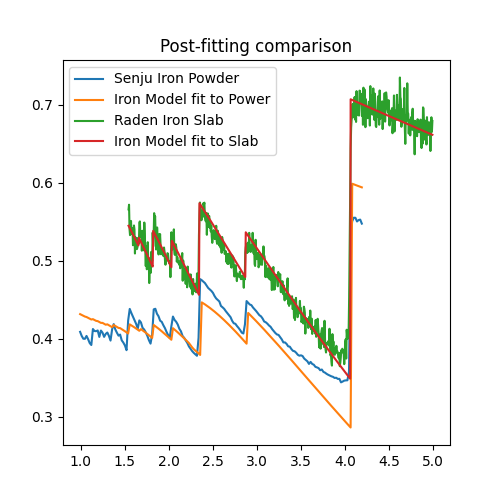

In [44]:
plt.figure(figsize=(5,5))
plt.plot(wavelengths, sliced_data.values, label='Senju Iron Powder')
plt.plot(wavelengths, simulated, label="Iron Model fit to Power")
plt.plot(slab_wavelengths, slab_transmissions, label="Raden Iron Slab")
plt.plot(slab_wavelengths, simulated_slab, label='Iron Model fit to Slab')
plt.title("Post-fitting comparison")
plt.legend()
plt.show()